# Augmented Reality with Planar Homographies


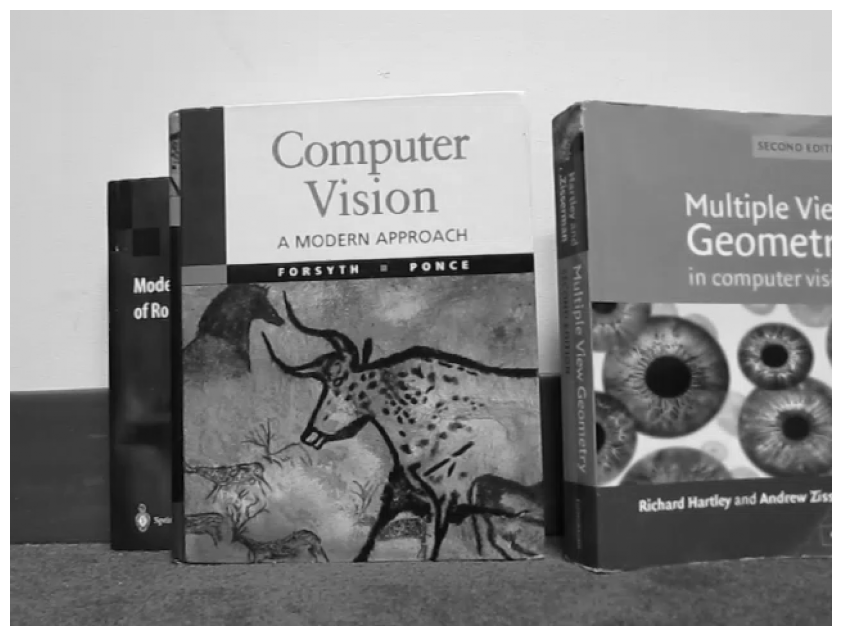

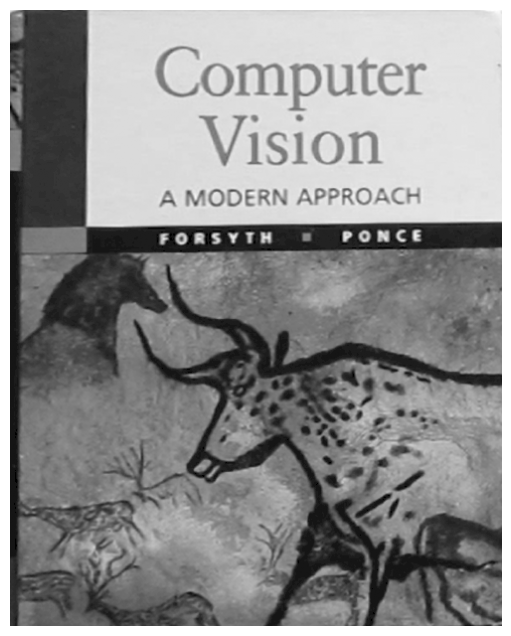

In [6]:
import cv2
import matplotlib.pyplot as plt

def plot(frame, cmap=None):
    plt.figure(figsize=(15, 8))
    if cmap:
        plt.imshow(frame, cmap= cmap)
    else:
        plt.imshow(frame)
    plt.axis('off')
    plt.show()
    
# Load book image
book_img = cv2.imread('materials/book2.png', cv2.IMREAD_GRAYSCALE)

# Load the first frame of the video
cap = cv2.VideoCapture('materials/book.mov')
ret, first_frame = cap.read()
cap.release()

first_frame_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
plot(first_frame_gray, "gray")
plot(book_img, "gray")

## Getting Correspondences 

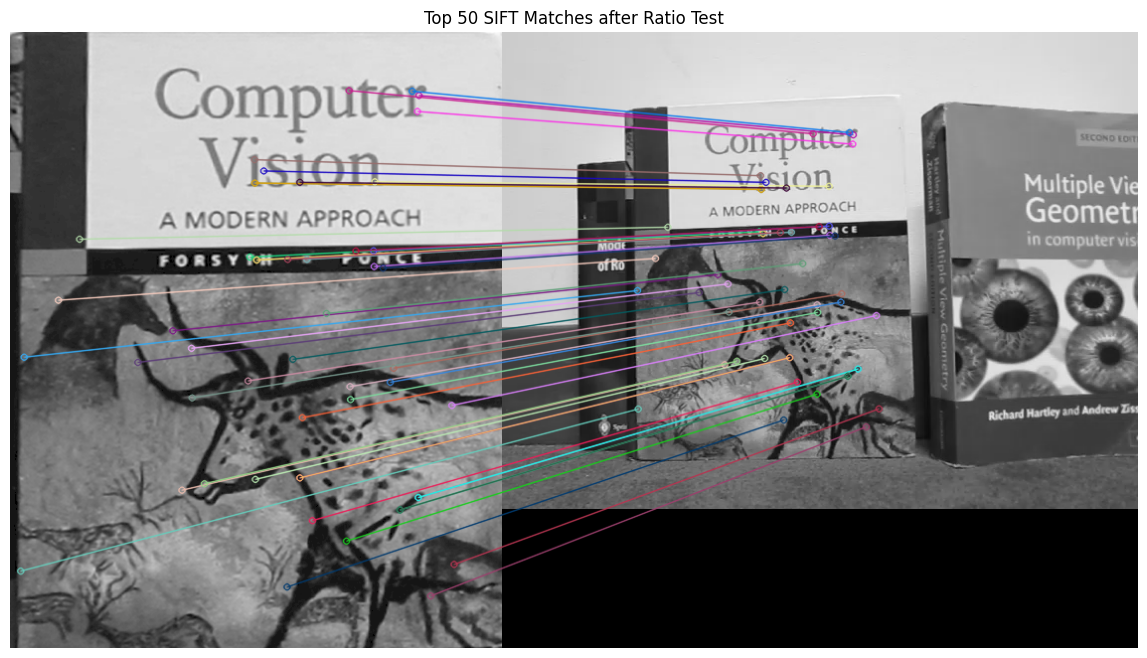

In [7]:
def get_correspondences(book_img, frame):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(book_img, None)
    kp2, des2 = sift.detectAndCompute(frame, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    
    # Apply Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    
    # Select 50 best matches
    good_matches = sorted(good_matches, key=lambda x: x.distance)[:50]

    return good_matches, kp1, kp2

good_matches, kp1,kp2 = get_correspondences(book_img, first_frame_gray)
matched_img = cv2.drawMatches(book_img, kp1, first_frame_gray, kp2, good_matches, None, flags=2) 
plt.figure(figsize=(15, 8))
plt.imshow(matched_img)
plt.title('Top 50 SIFT Matches after Ratio Test')
plt.axis('off')
plt.show()

## Compute the Homography Parameters

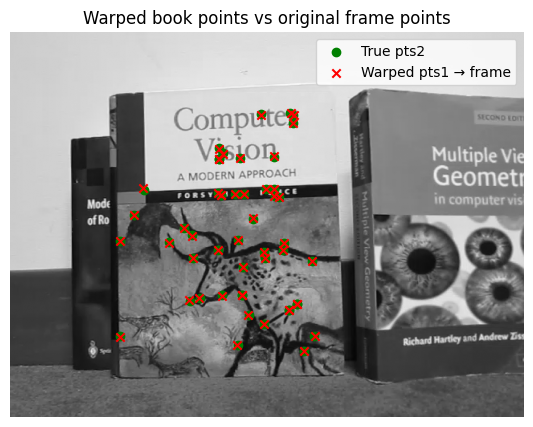

In [8]:
import numpy as np

# Get the coordinates of the points in both images
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

# Compute Homography using our function
def compute_homography(pts1, pts2):
    A = []
    for (x1, y1), (x2, y2) in zip(pts1, pts2):
        A.append([-x1, -y1, -1, 0, 0, 0, x2 * x1, x2 * y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2 * x1, y2 * y1, y2])
    A = np.array(A)
    _, _, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)
    return H / H[2, 2]

H = compute_homography(pts1, pts2)

# Warp pts1 using H
def warp_points(H, pts):
    pts_homogeneous = np.hstack([pts, np.ones((pts.shape[0], 1))])
    pts_warped_h = (H @ pts_homogeneous.T).T
    pts_warped = pts_warped_h[:, :2] / pts_warped_h[:, 2, np.newaxis]
    return pts_warped

pts1_warped = warp_points(H, pts1)

# Visualize how well warped pts1 aligns with pts2
plt.figure(figsize=(10, 5))
plt.imshow(first_frame_gray, cmap='gray')
plt.scatter(pts2[:, 0], pts2[:, 1], c='g', label='True pts2')
plt.scatter(pts1_warped[:, 0], pts1_warped[:, 1], c='r', marker='x', label='Warped pts1 → frame')
plt.legend()
plt.title("Warped book points vs original frame points")
plt.axis('off')
plt.show()

## Calculating book coordinates

In [10]:
def get_book_corners(homography, book_img):
    h, w = book_img.shape[:2]
    book_corners = np.array([
        [0, 0],       
        [w - 1, 0],   
        [w - 1, h - 1],
        [0, h - 1]      
    ], dtype=np.float32)
    
    mapped_corners = warp_points(homography, book_corners)
    frame_color = first_frame.

    return mapped_corners

warped_corners = get_book_corners(H, book_img)
pts = np.int32(mapped_corners).reshape((-1, 1, 2))
cv2.polylines(first_frame, [pts], isClosed=True, color=(0, 255, 0), thickness=2)    
plot(frame_color)



NameError: name 'mapped_corners' is not defined

## Cropping And Overlaying Video Frames

In [ ]:
def crop(frame, book_img):
    frame = frame[45:frame.shape[0]-45, :]
    h,w = book_img.shape
    ratio = w/h
    new_w = int(frame.shape[0] * ratio)
    x = frame.shape[1] // 2 - new_w //2 
    return  frame[:, x: x + new_w]

def overlay(cropped_frame, mapped_corners, frame_color):
    h_crop, w_crop = cropped_frame.shape[:2]
    movie_corners = np.array([
        [0, 0],
        [w_crop - 1, 0],
        [w_crop - 1, h_crop - 1],
        [0, h_crop - 1]
    ], dtype=np.float32)

    # Calculate homography of movie to book
    H_movie_to_book = compute_homography(movie_corners, mapped_corners)
    warped_movie = warp_points(H_movie_to_book, movie_corners)

    warped_movie_frame = cv2.warpPerspective(cropped_frame, H_movie_to_book, (frame_color.shape[1], frame_color.shape[0]))
    # Create a mask for the warped region to combine with the movite
    mask = np.zeros_like(frame_color, dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32(warped_movie), (255, 255, 255))
    masked_frame = cv2.bitwise_and(frame_color, cv2.bitwise_not(mask))
    
    final = cv2.add(masked_frame, cv2.bitwise_and(warped_movie_frame, mask))
    return final

cap = cv2.VideoCapture('materials/ar_source.mov')
_, movie_frame =  cap.read()

cropped = crop(movie_frame, book_img)
final = overlay(cropped, warped_corners, first_frame)
plot(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib

## Putting it all together

In [ ]:

cap = cv2.VideoCapture('materials/ar_source2.mp4')
cap2 = cv2.VideoCapture('materials/book.mov')

book_img = cv2.imread('materials/book2.png', cv2.IMREAD_GRAYSCALE)

while cap.isOpened() and cap2.isOpened():
    ret, movie_frame = cap.read()
    ret, book_frame = cap2.read()
    if not ret:
        break  # Exit loop when video ends

    good_matches, kp1, kp2 = get_correspondences(book_img, book_frame)
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])
    
    H = compute_homography(pts1, pts2)
    warped_corners = get_book_corners(H, book_img)
    
    cropped = crop(movie_frame, book_img)
    
    final_frame = overlay(cropped, warped_corners, book_frame)
    
    # Display the final frame with movie overlaid on book using OpenCV
    cv2.imshow('Overlayed Movie Frame on Book', final_frame)

    # Break on 'q' key press to stop the loop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close any OpenCV windows
cap.release()
cap2.release()
cv2.destroyAllWindows()